# ARFS - user defined cross validation scheme - Time series applicaition

You can pass your own cross validation scheme to `GrootCV`. It might be useful for time series applications.



In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit

from arfs.benchmark import highlight_tick
from arfs.feature_selection.allrelevant import GrootCV


bike_sharing = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True)
df = bike_sharing.frame

y = df["count"] #/ df["count"].max()

X = df.drop("count", axis="columns")
X["weather"] = (
    X["weather"]
    .astype(object)
    .replace(to_replace="heavy_rain", value="rain")
    .astype("category")
)

In [2]:
X.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
0,spring,0,1,0,False,6,False,clear,9.84,14.395,0.81,0.0
1,spring,0,1,1,False,6,False,clear,9.02,13.635,0.80,0.0
2,spring,0,1,2,False,6,False,clear,9.02,13.635,0.80,0.0
3,spring,0,1,3,False,6,False,clear,9.84,14.395,0.75,0.0
4,spring,0,1,4,False,6,False,clear,9.84,14.395,0.75,0.0


In [3]:
X["random_num"] = np.random.uniform(0,1,size=len(X))

In [4]:
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    max_train_size=10000,
    test_size=1000,
)

In [5]:
gbrt = HistGradientBoostingRegressor(categorical_features="from_dtype", random_state=42, loss="poisson")
categorical_columns = X.columns[X.dtypes == "category"]
print("Categorical features:", categorical_columns.tolist())

Categorical features: ['season', 'holiday', 'workingday', 'weather']


In [6]:
def evaluate(model, X, y, cv, model_prop=None, model_step=None):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
        return_estimator=model_prop is not None,
    )
    if model_prop is not None:
        if model_step is not None:
            values = [
                getattr(m[model_step], model_prop) for m in cv_results["estimator"]
            ]
        else:
            values = [getattr(m, model_prop) for m in cv_results["estimator"]]
        print(f"Mean model.{model_prop} = {np.mean(values)}")
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )


evaluate(gbrt, X, y, cv=ts_cv, model_prop="n_iter_")

Mean model.n_iter_ = 100.0
Mean Absolute Error:     42.744 +/- 1.721
Root Mean Squared Error: 67.084 +/- 3.941


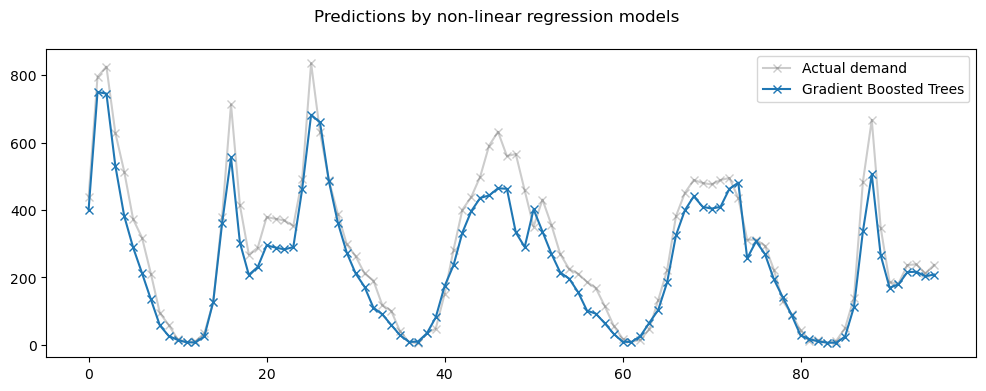

In [7]:
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]

gbrt.fit(X.iloc[train_0], y.iloc[train_0])
gbrt_predictions = gbrt.predict(X.iloc[test_0])

last_hours = slice(-96, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by non-linear regression models")
ax.plot(
    y.iloc[test_0].values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(
    gbrt_predictions[last_hours],
    "x-",
    label="Gradient Boosted Trees",
)
_ = ax.legend()

Cross Validation:   0%|          | 0/5 [00:00<?, ?it/s]

The selected features: ['season' 'year' 'month' 'hour' 'holiday' 'weekday' 'workingday' 'weather'
 'temp' 'feel_temp' 'humidity' 'windspeed' 'random_num']
The agnostic ranking: [2 2 2 2 2 2 2 2 2 2 2 2 2]
The naive ranking: ['ShadowVar10', 'ShadowVar13', 'ShadowVar11', 'ShadowVar4', 'ShadowVar9', 'ShadowVar12', 'ShadowVar3', 'ShadowVar7', 'ShadowVar6', 'ShadowVar1', 'ShadowVar8', 'ShadowVar2', 'ShadowVar5']


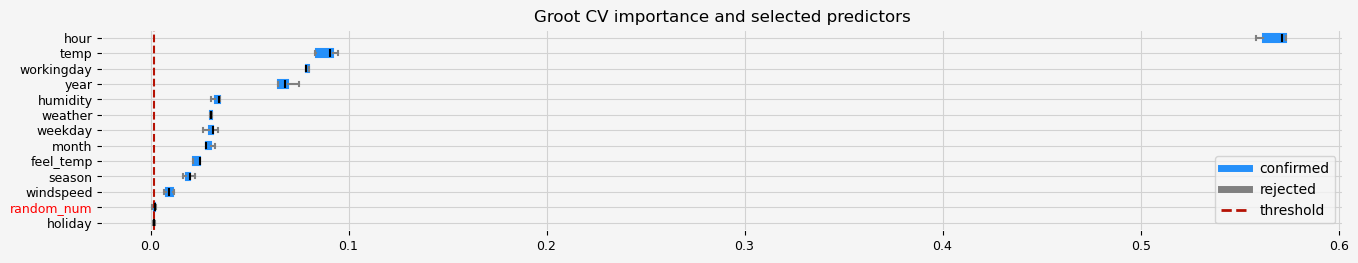

In [9]:

feat_selector = GrootCV(
    objective="poisson",
    cutoff=1,
    n_folds=5,
    folds=ts_cv,
    n_iter=5,
    silent=True,
    fastshap=False,
    n_jobs=0,
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

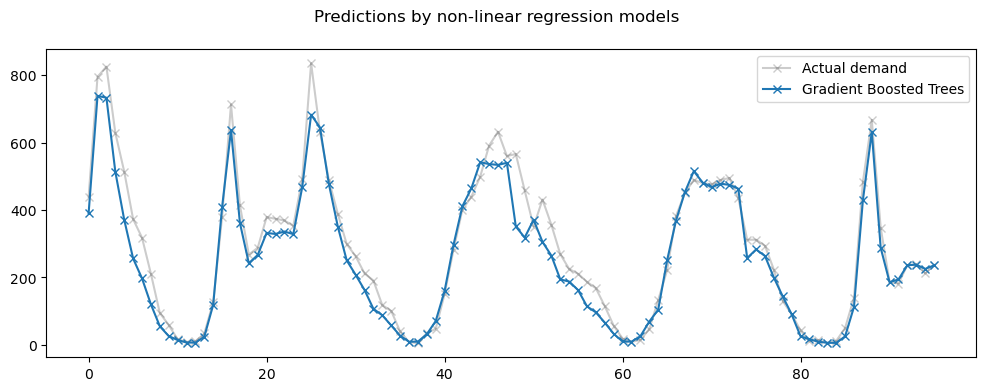

In [11]:
X_fs = X.drop(columns=["random_num", "holiday"])

all_splits = list(ts_cv.split(X_fs, y))
train_0, test_0 = all_splits[0]

gbrt.fit(X.iloc[train_0], y.iloc[train_0])
gbrt_predictions = gbrt.predict(X.iloc[test_0])

last_hours = slice(-96, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by non-linear regression models")
ax.plot(
    y.iloc[test_0].values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(
    gbrt_predictions[last_hours],
    "x-",
    label="Gradient Boosted Trees",
)
_ = ax.legend()

In [12]:
evaluate(gbrt, X_fs, y, cv=ts_cv, model_prop="n_iter_")

Mean model.n_iter_ = 100.0
Mean Absolute Error:     41.277 +/- 2.951
Root Mean Squared Error: 64.586 +/- 5.453
